# BVA Decision Document: Citation Analysis

Extract citations for all documents and analyze their trends.

Update (04/27/2020): Plot appeal risk vs. citation rate by individual VLJs

Update (04/23/2020): Do VLJ-based analysis using VLJ metadata

Update (04/09/2020): Re-extracted citations for all documents (better match, both case and statutes), Successful extraction of VLJ names

Update (03/28/2020): Focus on appeal eligible cases

Original: Preliminary plots and analysis

## Setup

In [ ]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import locale
import time
import seaborn as sns
import pandas.util.testing as tm  # stupid warning
from pandas.plotting import register_matplotlib_converters
from fuzzywuzzy import process
register_matplotlib_converters()
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'en_US.UTF-8'

## Connect to MongoDB

Database credentials are in `db_config.py` stored in the GCP bucket to ensure security.

In [ ]:
import pymongo
import os
os.chdir('/bva-data/')
from db_config import *

# connect to mongo database
db = pymongo.MongoClient(host=DB_HOST, port=DB_PORT)[DB_DATABASE]
db.authenticate(DB_USER, DB_PASSWORD)

True

In [ ]:
# total number of documents
db.documents.estimated_document_count()

1024074

In [ ]:
# example scraped metadata structure
db.appeals_meta_wscraped.find_one()

{'_id': ObjectId('5e98ad7d3397da26e5db1eca'),
 'appeal_id': '2683699',
 'appealed_CAVC': '0',
 'appealed_cavc_appeal_level': '0',
 'bfattid': '582',
 'bfmemid': '809',
 'bfso': 'L',
 'ctyp_ps1': '0',
 'ctyp_ps2': '0',
 'ctyp_ps3': '1',
 'ctyp_ps4': '0',
 'ctyp_ps5': '0',
 'ctyp_ps6': '0',
 'ctyp_ps7': '0',
 'ctyp_ps8': '0',
 'ctyp_ps9': '0',
 'cvdisp': '',
 'cvdocket': '',
 'cvjoint': '0',
 'imgadtm': '2015-07-24',
 'isscode': '3',
 'issdc': '4',
 'isslev2': 'NA',
 'isslev3': 'NA',
 'issprog': '7',
 'issseq': '1',
 'issue_count': '1',
 'issue_id': '2683699-1-1',
 'jmr_appeal_level': '0',
 'sa_name': 'ECKART,CAROL L',
 'sdob': '1924-05-20',
 'tiread2': '1531824',
 'vlj_name': 'BUSH,SONNET B'}

In [ ]:
# filter single issue cases
single_meta = pd.DataFrame(list(
    db.appeals_meta_wscraped.find({"issue_count": "1"})
))
single_meta.head()

,_id,appeal_id,tiread2,issue_id,imgadtm,issdc,issseq,issprog,isscode,isslev2,isslev3,cvdocket,cvdisp,appealed_CAVC,issue_count,cvjoint,appealed_cavc_appeal_level,jmr_appeal_level,bfso,bfmemid,bfattid,vlj_name,sa_name,sdob,ctyp_ps1,ctyp_ps2,ctyp_ps3,ctyp_ps4,ctyp_ps5,ctyp_ps6,ctyp_ps7,ctyp_ps8,ctyp_ps9
0,5e98ad7d3397da26e5db1eca,2683699,1531824,2683699-1-1,2015-07-24,4,1,7,3,NA,NA,,,0,1,0,0,0,L,809,582,"BUSH,SONNET B","ECKART,CAROL L",1924-05-20,0,0,1,0,0,0,0,0,0
1,5e98ad7d3397da26e5db1ed1,1658667,0633210,1658667-1-1,2006-10-17,4,1,2,15,8199,NA,,,0,1,0,0,0,L,44,805,"DAY,JONATHAN E","BUCK,BETHANY L",1930-04-04,0,0,0,1,1,0,0,0,0
2,5e98ad7d3397da26e5db1ed2,1459483,0503017,1459483-1-1,2005-01-19,3,1,2,15,8199,NA,,,0,1,0,0,0,L,44,805,"DAY,JONATHAN E","BUCK,BETHANY L",1930-04-04,0,0,0,1,1,0,0,0,0
3,5e98ad7d3397da26e5db1ed8,3596794,1745456,3596794-1-1,2017-10-10,1,1,2,17,NA,NA,,,0,1,0,0,0,D,1062,1965,"BRUCE,CYNTHIA M","SNOPARSKY,APRIL E.B.",1930-05-14,0,0,0,0,1,0,0,0,0
4,5e98ad7d3397da26e5db1ee6,1632705,0944665,1632705-1-1,2009-11-19,3,1,2,12,7319,NA,,,0,1,0,0,0,D,17,1118,"BRAEUER,WAYNE M","HADDOCK,KRISTIN A",1933-02-25,0,0,0,0,1,1,1,0,0


## Extract VLJ names from documents

The `judge_list.csv` file can be downloaded from the `regex files` folder in the shared Google Drive.

In [ ]:
# Import a dataset of the VLJs copied from the VA's 2010-2017 annual reports
judges = pd.read_csv("judge_list.csv")

# Now create a little utility function to grab the first initials and last name of the judge
def get_shortname(judgename):
    """
    Given an unedited judge name (e.g., "Wayne M. Braeuer, Jr.") return a shortened version
    of the name with first initials and last name ("W. M. Braeuer"). This format is closer
    to the style used in BVA decisions and will facilitate matching.
    """
    
    parts = [part.replace(',','') for part in judgename.split(' ')] # strip internal commas
    # First split: if the judge has a middle initial ("M."), grab the first two initials
    if len(parts[1]) == 2:
        initials = parts[0][0] + ". " + parts[1]
        # If they have a suffix. . . 
        if len(parts) > 3:
            if parts[3] in ["Jr.", "Sr.", "II", "III", "IV", "V"]:
                # Discard the suffix
                shortname = initials + " " + parts[2]
            else:
                # If it's a double last name keep it
                shortname = initials + " " + parts[2] + " " + parts[3]
        else: # If no suffix then just take the last name
            shortname = initials + " " + parts[2]
    else:
        initials = parts[0][0] + ". "
        if len(parts) > 2: # if no middle initial then suffix would be in third position
            if parts[2] in ["Jr.", "Sr.", "II", "III", "IV", "V"]:
                shortname = initials + " " + parts[1]
            else:
                shortname = initials + " " + parts[1] + " " + parts[2]
        else:
            shortname = initials + " " + parts[1]
    return shortname

# Now use this utility function to clean our ground truth list of judges
judges['shortname'] = [get_shortname(row[1]['judge.name']) for row in judges.iterrows()]
judges.head()

,judge.name,title,FY,link,shortname
0,Alan S. Peevy,Veterans' Law Judge,2013,https://www.bva.va.gov/docs/Chairmans_Annual_R...,A. S. Peevy
1,Alan S. Peevy,Veterans' Law Judge,2010,https://www.bva.va.gov/docs/Chairmans_Annual_R...,A. S. Peevy
2,Anne E. Jaeger,Veterans' Law Judge,2013,https://www.bva.va.gov/docs/Chairmans_Annual_R...,A. E. Jaeger
3,Donnie R. Hachey,Chief Counsel for Operations,2017,https://www.bva.va.gov/docs/Chairmans_Annual_R...,D. R. Hachey
4,James D. Ridgway,Chief Counsel for Policy and Procedure,2017,https://www.bva.va.gov/docs/Chairmans_Annual_R...,J. D. Ridgway


In [ ]:
# Create little utility for taking a tuple of byte text and returning a tuple of unicode text
def convert(bytetuple):
    return tuple([s.decode("utf-8", "ignore") for s in bytetuple])

# Build function to obtain VLJ names
def get_names(string, judge_list=judges, noisy=False):
    """ 
    Given the text of a BVA decision and a data.frame containing an authoritative
    list of BVA judges, return the name of a known judge who authored the decision. 
    
    inputs: @string: the BVA opinion in byte format
            @judge_list: a pd.DataFrame containing the column 'shortname' which is the
                        standardized format for names we created above. 
    outputs: @processed: a list of 5 elements containing the 5 best guesses for who the
                        deciding judge was. 
    """
    # First, grab the part of the opinion that comes at the end--either beneath the signature line 
    # or after the ORDER
    
    end = re.search(b'(______+.*[\s]+.*)|(ORDER[.\s]+)(.*)', string, re.DOTALL)
    if end:
        end = end.group()
    else:
        return []
        # return [np.NaN for a in np.arange(5)]
    
    # Then extract *all* of the names on the opinion. 
    
    names = re.findall(b'([A-Z]+\.?)( *[A-Z]*\.?)( [A-Z][A-Za-z]+)', end)
    names = [''.join(convert(s)) for s in names]
    names = [name[0] + ". " + name.split(' ')[-1] for name in names]
    
    if noisy: # this is just for dev purposes
        print([process.extract(name, judge_list['shortname'], limit=50) for name in names])
    
    # Now grab all of the names in our authoritative list that have an 
    # acceptably close edit distance to each of the names we got from our file
    # and discard the edit distance score
    
    matched = [process.extractOne(name, judge_list['shortname'], score_cutoff=90) for name in names]
    matched = list(set([name[0] for name in matched if name is not None]))
    return matched

In [ ]:
def extract_vljs(document):
    """Convert text string to bytes and pass to extraction"""
    return get_names(document.get('txt').encode('utf-8'))

In [ ]:
# test VLJ name extraction
document = db.documents.find_one()
extract_vljs(document)

['A. M. Bryant']

Now let's get all the single-issue decision texts and extract the VLJ names. Results will be inserted into the `vlj_names` field in `db.documents`.

In [ ]:
# extract VLJ names for all single-issue documents
# find documents: ~15 minutes
single_documents = list(db.documents.find(
    {"bva_id": {"$in": single_meta.tiread2.tolist()}},
    {"_id": 1, "bva_id": 1, "txt": 1}
))

In [ ]:
# use multiprocessing to accelerate
# this is FAR more time/memory-consuming than I thought...
def chunk(collection, interval):
    for i in range(0, len(collection), interval):
        yield collection[i:i + interval]

def extract_vljs_for_chunk(document_chunk):
    child_db = pymongo.MongoClient(host=DB_HOST, port=DB_PORT)[DB_DATABASE]
    child_db.authenticate(DB_USER, DB_PASSWORD)
    operations = []

    for document in document_chunk:
        operations.append(pymongo.operations.UpdateOne(
            filter={"_id": document.get("_id")},
            update={"$set": {"vlj_names": extract_vljs(document)}}
        ))
    child_db.documents.bulk_write(operations)
    operations.clear()

t = datetime.datetime.now()
pool = multiprocessing.Pool()
pool.map(extract_vljs_for_chunk, list(chunk(single_documents, 1000)))
pool.close()
print(datetime.datetime.now() - t)

In [ ]:
db.documents.count_documents({"vlj_names": {"$exists": True}})

353662

In [ ]:
len(single_documents) # sanity check

353662

## Investigate the VLJ distribution

Since we have already extracted VLJ names for all these cases, let's retrieve them directly from the database.

Be sure to run through all the cells as there can be some transformations along the way.

In [ ]:
# somehow this doesn't work
# haven't figured out why, use the following workaround instead
"""
df = pd.DataFrame(list(
    db.appeals_meta_wscraped.aggregate([{
        '$match': {'issue_count': '1'}
    }, {
        '$lookup': {
            'from': 'documents', 
            'localField': 'tiread2', 
            'foreignField': 'bva_id',
            'as': 'metas'
        }
    }, {
        '$unwind': '$metas'
    }, {
        '$project': {
            '_id' : 0,
            'bva_id': 1,
            'timestamp': '$metas.imgadtm',
            'corrected_appealed_cavc': '$joined.appealed_cavc_appeal_level',
            'corrected_jmr': '$joined.jmr_appeal_level',
            'cvdisp': '$joined.cvdisp',
            'issdc': '$joined.issdc',
            'issprog': '$joined.issprog',
            'isscode': '$joined.isscode',
            'vlj_names': '$joined.vlj_names',
        }
    }
])))
df.head()
"""

A workaround to get the dataframe:

In [ ]:
# get metadata
meta = pd.DataFrame(list(
        db.appeals_meta_wscraped.find({"issue_count": "1"}, {
            "_id": 0, "tiread2": 1, "issdc": 1, "issprog": 1, "isscode": 1,
            "imgadtm": 1, "appealed_cavc_appeal_level": 1,
            "jmr_appeal_level": 1, "cvdisp": 1,
        })
    ))\
    .rename({
        "imgadtm": "timestamp",
        "appealed_cavc_appeal_level": "corrected_appealed_CAVC",
        "jmr_appeal_level": "corrected_jmr"
    }, axis='columns')\
    .drop_duplicates(subset='tiread2') # about 10 duplicates

In [ ]:
# get VLJ names, can take ~20 minutes
vlj_names = pd.DataFrame(list(
    db.documents.find(
        {"bva_id": {"$in": sorted(meta.tiread2.tolist())}},
        {"_id": 0, "bva_id": 1, "vlj_names": 1}
    )
))

In [ ]:
# join metadata with VLJ names to get our df
df = meta.merge(vlj_names, left_on='tiread2', right_on='bva_id', how='inner') \
         .drop('tiread2', axis='columns')
df['timestamp'] = pd.to_datetime(df.timestamp)
df['corrected_appealed_CAVC'] = df.corrected_appealed_CAVC.astype(int)
df['corrected_jmr'] = df.corrected_jmr.astype(int)
df

,timestamp,issdc,issprog,isscode,cvdisp,corrected_appealed_CAVC,corrected_jmr,bva_id,vlj_names
0,2001-09-17,3,2,12,,0,0,0122817,[]
1,2001-09-24,3,2,15,,0,0,0123419,[]
2,2008-07-21,3,2,15,,0,0,0824198,[L. H. Eskenazi]
3,2003-11-07,3,2,12,,0,0,0331171,[]
4,2001-01-19,4,2,12,,0,0,0101964,[D. C. Spickler]
...,...,...,...,...,...,...,...,...,...
353657,2002-10-28,1,2,12,,0,0,0215264,[]
353658,2000-12-26,1,2,12,,0,0,0100807,[S. L. Keller]
353659,2000-11-29,4,2,12,,0,0,0031043,[]
353660,2004-03-22,3,2,12,,0,0,0408240,[]


In [ ]:
# how many VLJs are in each document
df.vlj_names.str.len().value_counts()

1    277224
0     75605
3       440
2       332
4        40
5        13
6         5
9         2
7         1
Name: vlj_names, dtype: int64

In [ ]:
# split multiple VLJs into separate rows
df = df.explode('vlj_names').dropna()
df.head()

,timestamp,issdc,issprog,isscode,cvdisp,corrected_appealed_CAVC,corrected_jmr,bva_id,vlj_names
2,2008-07-21,3,2,15,,0,0,0824198,L. H. Eskenazi
4,2001-01-19,4,2,12,,0,0,0101964,D. C. Spickler
8,2000-10-31,1,2,9,,0,0,0028859,K. Gallagher
9,2000-11-09,4,2,16,,0,0,0029785,D. C. Spickler
11,2004-04-21,3,2,18,,0,0,0410694,K. W. Allen


In [ ]:
# count number of cases handled by a VLJ
df.groupby(df.vlj_names).bva_id.count().describe()

count     134.000000
mean     2085.731343
std      1881.072931
min         1.000000
25%       288.250000
50%      1457.500000
75%      3614.750000
max      6402.000000
Name: bva_id, dtype: float64

In [ ]:
df.groupby([df.vlj_names, df.timestamp.dt.year]).bva_id.count().describe()

count    1647.000000
mean      169.695203
std       147.282882
min         1.000000
25%        15.000000
50%       143.000000
75%       313.000000
max       556.000000
Name: bva_id, dtype: float64

In [ ]:
df.groupby([
    df.vlj_names, df.timestamp.dt.year, df.timestamp.dt.month
]).bva_id.count().describe()

count    15044.000000
mean        18.578038
std         12.880015
min          1.000000
25%          6.000000
50%         19.000000
75%         28.000000
max        116.000000
Name: bva_id, dtype: float64

### Combine citations and VLJ info

Here we will only focus on Thun v. Peake and explore what plots and statictics could be interesting.

In [ ]:
def find_cases_that_cite(citation):
    """
    Given a citation, find all cases that contain that citation
    @input: a dict conforming to the citation schema
    @output: a list of BVA IDs
    """
    return [info['bva_id']
        for info in list(db.citations.find(
            {'citations': {'$elemMatch': citation}},
            {'_id': 0, 'bva_id': 1}
        ))
    ]

def add_citation_indicator(df, citation):
    """
    Given a citation, indicate whether each case in df contains that citation
    @input: a dict conforming to the citation schema
    @output: a df with a column 'cited' indicating if cited the citation
    """
    df['cited'] = df.bva_id.isin(find_cases_that_cite(citation)).astype(int)
    return df

In [ ]:
# find related cases that might cite Thun v. Peake
# this may take ~20 seconds
related_df = df[
    (df.issprog == '2') & (df.isscode == '12')
    & ((df.issdc == '1') | (df.issdc == '4'))
    & (df.timestamp > pd.Timestamp('2008-01-01'))
].copy()

thun_v_peake = {'case': '22 Vet. App. 111'}
related_df = add_citation_indicator(related_df, thun_v_peake)
related_df

,timestamp,issdc,issprog,isscode,cvdisp,corrected_appealed_CAVC,corrected_jmr,bva_id,vlj_names,cited
9918,2008-10-01,4,2,12,,0,0,0833838,D. R. Brown,0
20847,2008-12-17,4,2,12,,0,0,0843991,J. J. Crowley,1
25882,2008-04-04,4,2,12,,0,0,0811357,J. Jones,0
27005,2009-12-23,1,2,12,,0,0,1000001,R. F. Williams,1
29378,2008-02-21,4,2,12,,0,0,0805839,C. O. Crawford,0
...,...,...,...,...,...,...,...,...,...,...
314239,2017-12-11,1,2,12,,0,0,1758650,S. C. Krembs,0
340580,2008-06-17,1,2,12,,0,0,0822741,A. MacKenzie,0
341564,2009-10-28,1,2,12,,0,0,0941154,L. A. Howell,0
341776,2008-05-01,1,2,12,,0,0,0814482,J. E. Ormond,0


## Question 1: How often do judges cite Thun v. Peake?

In [ ]:
def annotate_chart(ax, annotations):
    for annotation in annotations:
        date, text, pos = annotation
        ax.axvline(date, color='slategrey')
        ax.annotate(text, (date, pos), color='slategrey')
    return ax

thun_v_peake_annotations = [
    (datetime.datetime(2008, 4, 23), 'Case date\n(April 2008)', 0.9),
    (datetime.datetime(2017, 4, 27), 'Email\n(April 2017)', 0.9),
    (datetime.datetime(2017, 8, 31), 'Training\n(August 2017)', 0.8)
]

In [ ]:
# number of cases each judge has handled
case_counts = related_df.groupby('vlj_names').bva_id.count()
case_counts.describe()

count    121.000000
mean     187.214876
std      143.203131
min        1.000000
25%       45.000000
50%      173.000000
75%      320.000000
max      500.000000
Name: bva_id, dtype: float64

In [ ]:
# find experienced and inexperienced judges
top_judges = case_counts.nlargest(10)
bottom_judges = case_counts[case_counts > 90].nsmallest(10)
bottom_judges

vlj_names
R. F. Williams     91
K. M. Millikan     92
H. L. Seesel       94
R.  Feinberg       97
K. E. Osborne     103
A. P. Simpson     106
B.  Hennings      116
G. E. Strommen    127
B. L. Buck        129
A.  MacKenzie     132
Name: bva_id, dtype: int64

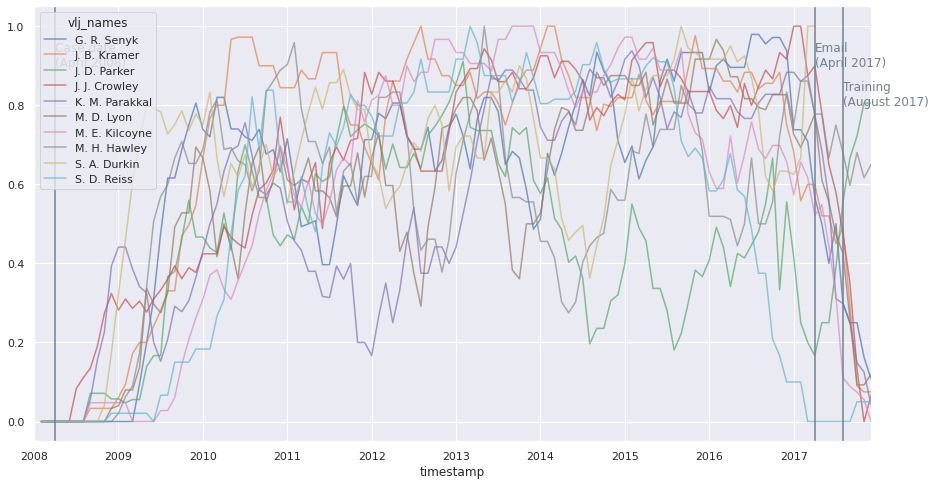

In [ ]:
# plot citation rate for experienced judges
sns.set()
plt.figure(figsize=(15, 8))
ax = plt.gca()

related_df[related_df.vlj_names.isin(top_judges.index)]\
    .groupby([pd.Grouper(key='timestamp', freq='M'), 'vlj_names'])\
    .cited.mean().unstack()\
    .rolling(6, min_periods=2).mean()\
    .plot(ax=ax, alpha=.7)

annotate_chart(ax, thun_v_peake_annotations)

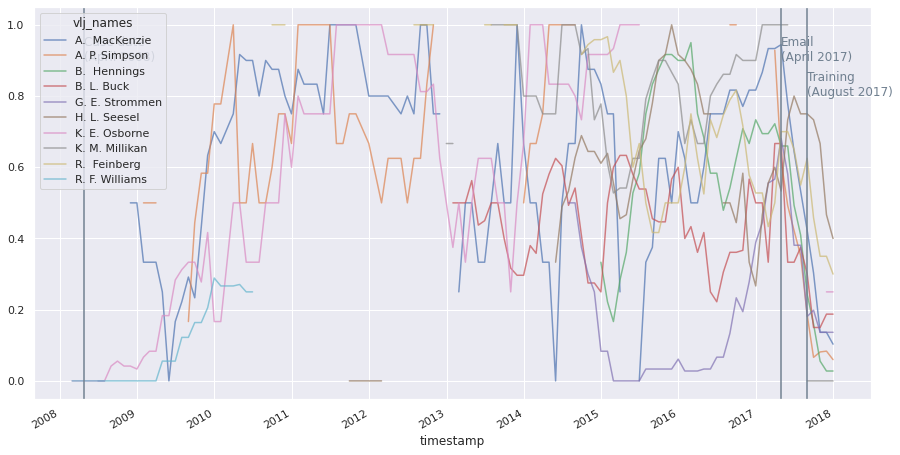

In [ ]:
# plot citation rate for inexperienced judges
plt.figure(figsize=(15, 8))
ax = plt.gca()
related_df[related_df.vlj_names.isin(bottom_judges.index)]\
    .groupby([pd.Grouper(key='timestamp', freq='M'), 'vlj_names'])\
    .cited.mean().unstack()\
    .rolling(6, min_periods=2).mean()\
    .plot(ax=ax, alpha=.7)

annotate_chart(ax, thun_v_peake_annotations)

(74, 8)


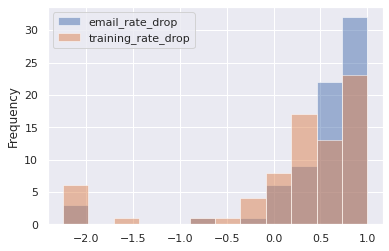

In [ ]:
# compute citation rate drop before/after the email and the training
before_email = (related_df.timestamp > pd.Timestamp(2017, 1, 1)) \
        & (related_df.timestamp < pd.Timestamp(2017, 4, 30))
after_email = (related_df.timestamp > pd.Timestamp(2017, 5, 1)) \
        & (related_df.timestamp < pd.Timestamp(2017, 8, 31))

before_training = (related_df.timestamp > pd.Timestamp(2017, 5, 1)) \
        & (related_df.timestamp < pd.Timestamp(2017, 8, 31))
after_training = (related_df.timestamp > pd.Timestamp(2017, 9, 1)) \
        & (related_df.timestamp < pd.Timestamp(2017, 12, 31))

rate_drop = pd.concat([
    related_df[before_email].groupby('vlj_names').cited.count().rename('before_email_count'),
    related_df[before_email].groupby('vlj_names').cited.mean().rename('before_email_rate'),
    related_df[after_email].groupby('vlj_names').cited.count().rename('after_email_count'),
    related_df[after_email].groupby('vlj_names').cited.mean().rename('after_email_rate'),
    related_df[before_training].groupby('vlj_names').cited.count().rename('before_training_count'),
    related_df[before_training].groupby('vlj_names').cited.mean().rename('before_training_rate'),
    related_df[after_training].groupby('vlj_names').cited.count().rename('after_training_count'),
    related_df[after_training].groupby('vlj_names').cited.mean().rename('after_training_rate'),
], axis=1)
rate_drop = rate_drop[rate_drop.before_email_rate + rate_drop.after_email_rate > 0]
rate_drop = rate_drop[rate_drop.before_training_rate + rate_drop.after_training_rate > 0]
print(rate_drop.shape)

rate_drop['email_rate_drop'] = (
    (rate_drop.before_email_rate - rate_drop.after_email_rate) / rate_drop.before_email_rate
).replace(-np.inf, -2.)
rate_drop['training_rate_drop'] = (
    (training_rate_drop.before_training_rate - training_rate_drop.after_training_rate)
    / training_rate_drop.before_training_rate
).replace(-np.inf, -2.)
rate_drop[['email_rate_drop', 'training_rate_drop']].plot.hist(bins=12, alpha=.5)

In [ ]:
# investigate if slower judges are doing better after training
d1 = rate_drop[rate_drop['email_rate_drop'] < 0.5].sort_values('email_rate_drop')
d1.index.size

20

In [ ]:
d2 = rate_drop[rate_drop['training_rate_drop'] > 0.5].sort_values('training_rate_drop')
d2.index.size

35

In [ ]:
d2.index.intersection(d1.index).size

10

In [ ]:
# who didn't show a rate drop?
rate_drop[rate_drop['email_rate_drop'] < 0].sort_values('email_rate_drop')

,before_email_count,before_email_rate,after_email_count,after_email_rate,before_training_count,before_training_rate,after_training_count,after_training_rate,email_rate_drop,training_rate_drop
D. R. Brown,1.0,0.000000,8.0,0.250000,8.0,0.250000,12.0,0.000000,-2.000000,1.000000
J. D. Parker,13.0,0.000000,15.0,0.866667,15.0,0.866667,15.0,0.666667,-2.000000,0.230769
M. Blackwelder,4.0,0.000000,26.0,0.076923,26.0,0.076923,18.0,0.000000,-2.000000,1.000000
B. B. Copeland,8.0,0.250000,17.0,0.411765,17.0,0.411765,15.0,0.133333,-0.647059,0.676190
J. Jones,3.0,0.333333,5.0,0.400000,5.0,0.400000,1.0,1.000000,-0.200000,-1.500000
G. R. Senyk,3.0,0.333333,20.0,0.350000,20.0,0.350000,18.0,0.055556,-0.050000,0.841270


In [ ]:
rate_drop[rate_drop['training_rate_drop'] < 0].sort_values('training_rate_drop')

,before_email_count,before_email_rate,after_email_count,after_email_rate,before_training_count,before_training_rate,after_training_count,after_training_rate,email_rate_drop,training_rate_drop
M. L. Kane,9.0,0.333333,13.0,0.076923,13.0,0.076923,8.0,0.250000,0.769231,-2.250000
J. Zissimos,1.0,1.000000,10.0,0.000000,10.0,0.000000,10.0,0.200000,1.000000,-2.000000
L. M. Barnard,4.0,0.500000,14.0,0.000000,14.0,0.000000,6.0,0.166667,1.000000,-2.000000
M. A. Pappas,7.0,0.285714,12.0,0.000000,12.0,0.000000,6.0,0.166667,1.000000,-2.000000
M. D. Hindin,15.0,0.466667,13.0,0.000000,13.0,0.000000,14.0,0.142857,1.000000,-2.000000
R. T. Kessel,9.0,0.444444,10.0,0.000000,10.0,0.000000,15.0,0.133333,1.000000,-2.000000
J. Jones,3.0,0.333333,5.0,0.400000,5.0,0.400000,1.0,1.000000,-0.200000,-1.500000
S. B. Mays,6.0,1.000000,10.0,0.100000,10.0,0.100000,6.0,0.166667,0.900000,-0.666667
A. Caracciolo,3.0,1.000000,13.0,0.076923,13.0,0.076923,8.0,0.125000,0.923077,-0.625000
H. N. Schwartz,10.0,0.800000,11.0,0.090909,11.0,0.090909,18.0,0.111111,0.886364,-0.222222


## Question 2: Do judges that cite Thun v. Peake have differences in appeal risk?

### Qualitative visualization

In [ ]:
cited_df = related_df[related_df.cited == 1]
not_cited_df = related_df[related_df.cited == 0]

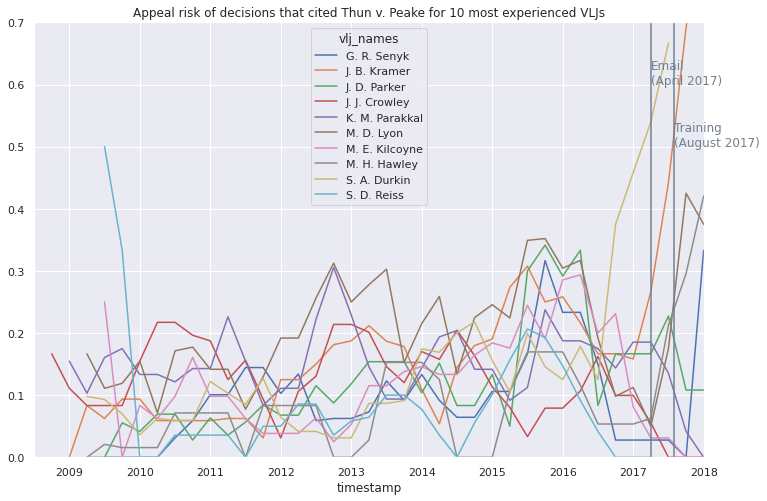

In [ ]:
# plot appeal risks of 10 most experiencend VLJs
plt.figure(figsize=(12, 8))
ax = plt.gca()

more_top_judges = case_counts.nlargest(10)

cited_df[cited_df.vlj_names.isin(more_top_judges.index)]\
    .groupby([pd.Grouper(key='timestamp', freq='3M'), 'vlj_names'])\
    .corrected_appealed_CAVC.mean().unstack()\
    .rolling(4, min_periods=2).mean()\
    .plot(ax=ax, ylim=(0, 0.7),
          title='Appeal risk of decisions that cited Thun v. Peake for 10 most experienced VLJs')

thun_v_peake_adjusted_annotations = [
    (datetime.datetime(2008, 4, 23), 'Case date\n(April 2008)', 0.4),
    (datetime.datetime(2017, 4, 27), 'Email\n(April 2017)', 0.6),
    (datetime.datetime(2017, 8, 31), 'Training\n(August 2017)', 0.5)
]
annotate_chart(ax, thun_v_peake_adjusted_annotations)

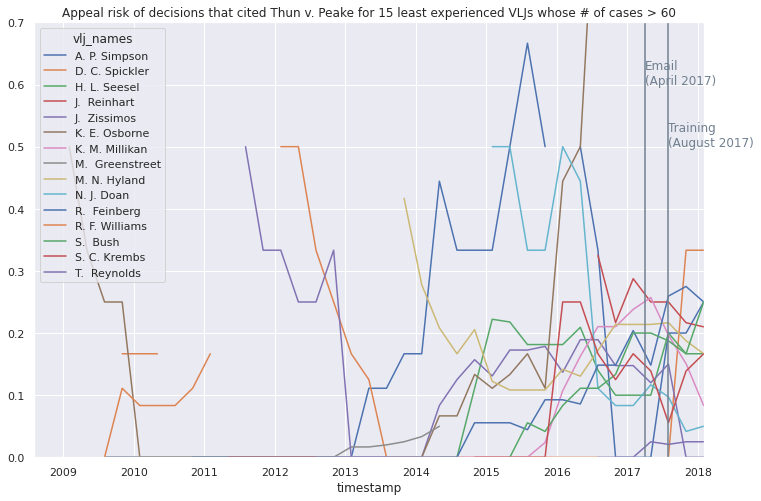

In [ ]:
# plot appeal risks of 15 least experiencend VLJs (# of cases > 60)
plt.figure(figsize=(12, 8))
ax = plt.gca()

more_bottom_judges = case_counts[case_counts > 60].nsmallest(15)

title = 'Appeal risk of decisions that cited Thun v. Peake for 15 least experienced VLJs whose # of cases > 60'
cited_df[cited_df.vlj_names.isin(more_bottom_judges.index)]\
    .groupby([pd.Grouper(key='timestamp', freq='3M'), 'vlj_names'])\
    .corrected_appealed_CAVC.mean().unstack()\
    .rolling(6, min_periods=2).mean()\
    .plot(ax=ax, ylim=(0, 0.7), title=title)

annotate_chart(ax, thun_v_peake_adjusted_annotations)

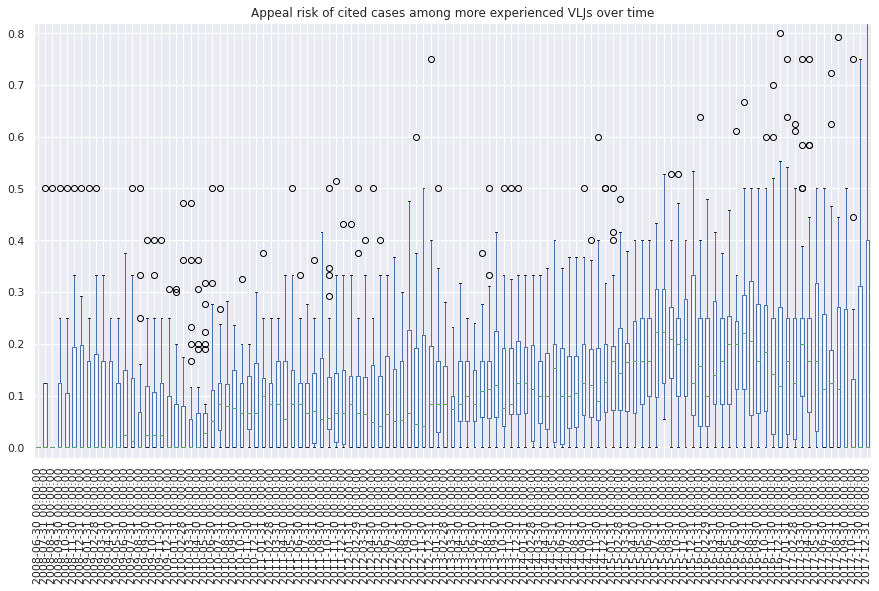

In [ ]:
# appeal risk distribution over time for more experienced VLJs (top 30)
plt.figure(figsize=(15, 8))
ax = plt.gca()

more_experienced = case_counts.nlargest(30)

title = 'Appeal risk of cited cases among more experienced VLJs over time'
cited_df[cited_df.vlj_names.isin(more_experienced.index)]\
    .groupby([pd.Grouper(key='timestamp', freq='M'), 'vlj_names'])\
    .corrected_appealed_CAVC.mean().unstack()\
    .rolling(6, min_periods=1).mean().T\
    .plot(kind='box', rot=90, ax=ax, ylim=(-0.02, 0.82), title=title)

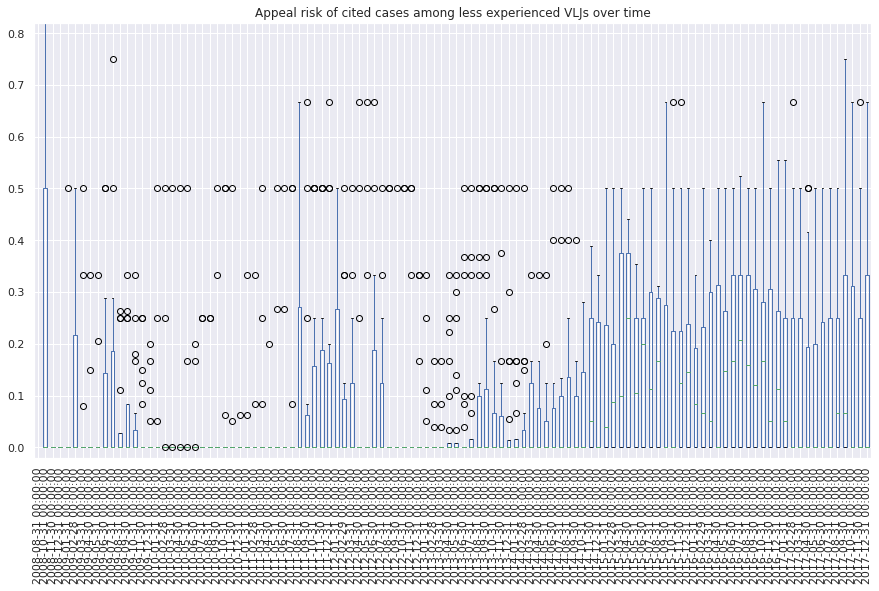

In [ ]:
# appeal risk distribution over time for less experienced VLJs (bottom 60)
plt.figure(figsize=(15, 8))
ax = plt.gca()

title = 'Appeal risk of cited cases among less experienced VLJs over time'
less_experienced = case_counts.nsmallest(60)

cited_df[cited_df.vlj_names.isin(less_experienced.index)]\
    .groupby([pd.Grouper(key='timestamp', freq='M'), 'vlj_names'])\
    .corrected_appealed_CAVC.mean().unstack()\
    .rolling(6, min_periods=1).mean().T\
    .plot(kind='box', rot=90, ax=ax, ylim=(-0.02, 0.82), title=title)

### Quantitative outlier detection

Now we use Local Outlier Factor (LOF) method to detect outliers quantitatively.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)

pd.set_option('display.max_rows', 100)
appeal_df = cited_df\
    .groupby([pd.Grouper(key='timestamp', freq='3M'), 'vlj_names'])\
    .corrected_appealed_CAVC.mean().unstack()\
    .rolling(4, min_periods=2).mean().T
X = appeal_df[appeal_df.isnull().sum(axis=1) < 10].copy()
for column in X.columns:
    X[column].fillna(X.mean(axis=1), inplace=True)
X.shape

(47, 39)

[-2.37601785 -2.01867244 -1.75440118 -1.58837655 -1.58456271 -1.55856529
 -1.51369781 -1.42817236 -1.34077907 -1.2965595  -1.29329845 -1.23253182
 -1.21428859 -1.17069713 -1.16018136 -1.14717045 -1.13845519 -1.09914037
 -1.09070951 -1.06924633 -1.05846084 -1.05141172 -1.04949213 -1.04719291
 -1.03362096 -1.03279919 -1.03265055 -1.02961729 -1.00601075 -1.00386551
 -1.00368202 -1.00007528 -0.99819493 -0.99741571 -0.99498185 -0.99271447
 -0.99081117 -0.99013757 -0.98948648 -0.98904425 -0.98899109 -0.98736731
 -0.98580122 -0.98533406 -0.98201864 -0.97721302 -0.97361545]


Text(0.5, 1.0, 'Local Outlier Factor (LOF)')

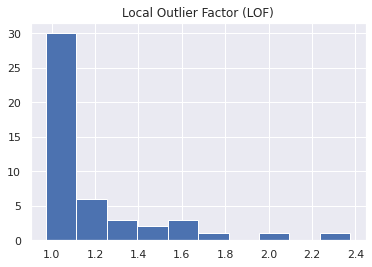

In [ ]:
clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_
print(np.sort(X_scores))
plt.hist(-X_scores)
plt.title('Local Outlier Factor (LOF)')

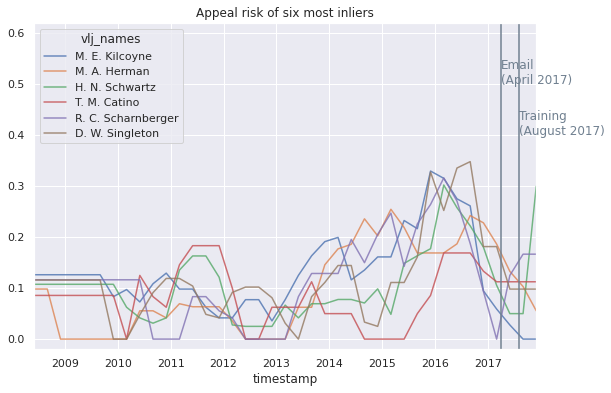

In [ ]:
# normal judges
plt.figure(figsize=(9, 6))
ax = plt.gca()
X.iloc[np.argsort(X_scores)[-6:], :].T.plot(
    ax=ax, ylim=(-0.02, 0.62), alpha=.8,
    title='Appeal risk of six most inliers'
)
annotate_chart(ax, thun_v_peake_adjusted_annotations)

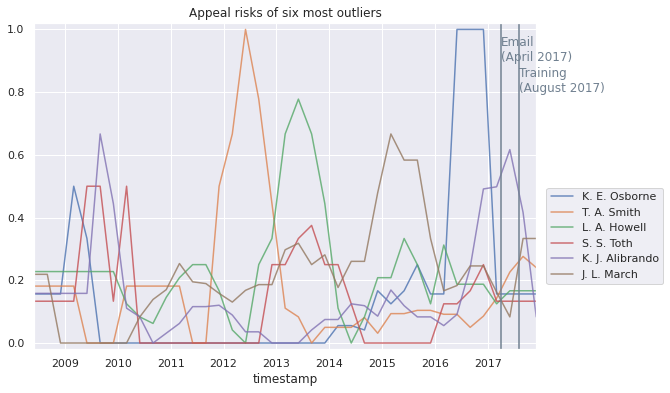

In [ ]:
# outliers
plt.figure(figsize=(9, 6))
ax = plt.gca()
X.iloc[np.argsort(X_scores)[:6], :].T.plot(
    ax=ax, ylim=(-0.02, 1.02), alpha=.8,
    title='Appeal risks of six most outliers'
)
ax.legend(loc=(1.02, 0.2))
annotate_chart(ax, thun_v_peake_annotations)

Why don't we repeat this process to answer Question 1?

(55, 41)
[-1.68978129 -1.55805031 -1.43462311 -1.39949276 -1.3825366  -1.31354599
 -1.29706634 -1.28235838 -1.2599247  -1.25613361 -1.2546086  -1.24960371
 -1.24868165 -1.24181534 -1.17823377 -1.15694011 -1.14838498 -1.13532306
 -1.12422396 -1.11276767 -1.1088936  -1.10197166 -1.10064743 -1.07222232
 -1.06370822 -1.05683623 -1.05637331 -1.05514954 -1.05480739 -1.0429488
 -1.03388658 -1.02831942 -1.02472778 -1.02274049 -1.01599044 -1.01317349
 -1.01273338 -1.01143878 -1.00963414 -0.99450676 -0.99036445 -0.98909785
 -0.98841463 -0.98826779 -0.98716147 -0.98647331 -0.98205102 -0.98088274
 -0.98004463 -0.97734097 -0.97561802 -0.9755448  -0.97386306 -0.97314605
 -0.97133517]


Text(0.5, 1.0, 'Local Outlier Factor (LOF)')

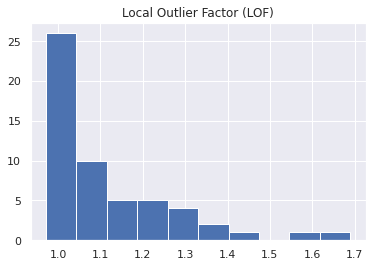

In [ ]:
# repeat outlier detection for citation rates
cites = related_df\
    .groupby([pd.Grouper(key='timestamp', freq='3M'), 'vlj_names'])\
    .cited.mean().unstack()\
    .rolling(4, min_periods=2).mean().T

X = cites[cites.isnull().sum(axis=1) < 10].copy()
for column in X.columns:
    X[column].fillna(X.mean(axis=1), inplace=True)
print(X.shape)

clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_
print(np.sort(X_scores))
plt.hist(-X_scores)
plt.title('Local Outlier Factor (LOF)')

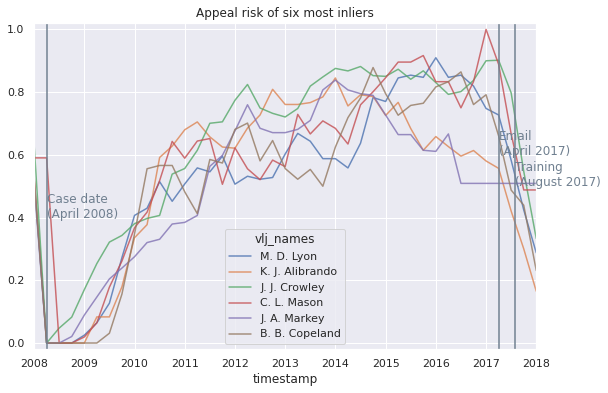

In [ ]:
# normal judges
plt.figure(figsize=(9, 6))
ax = plt.gca()
X.iloc[np.argsort(X_scores)[-6:], :].T.plot(
    ax=ax, ylim=(-0.02, 1.02), alpha=.8,
    title='Appeal risk of six most inliers'
)
annotate_chart(ax, thun_v_peake_adjusted_annotations)

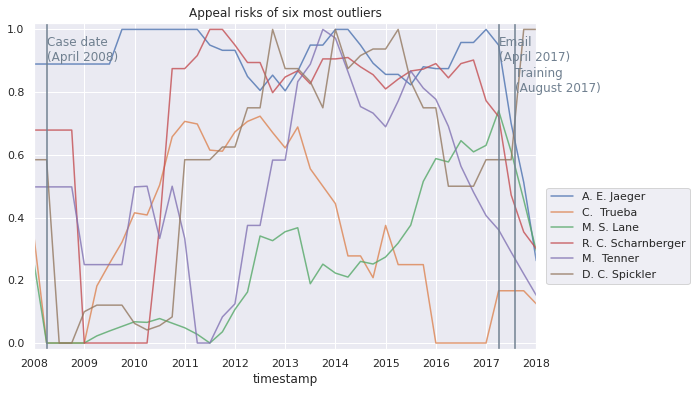

In [ ]:
# outliers
plt.figure(figsize=(9, 6))
ax = plt.gca()
X.iloc[np.argsort(X_scores)[:6], :].T.plot(
    ax=ax, ylim=(-0.02, 1.02), alpha=.8,
    title='Appeal risks of six most outliers'
)
ax.legend(loc=(1.02, 0.2))
annotate_chart(ax, thun_v_peake_annotations)

## Repeat outlier analysis above from VLJ metadata

In [ ]:
# filter single issue cases
df = pd.DataFrame(list(
    db.appeals_meta_wscraped.find({'issue_count': '1'}, {'_id': 0})
))
df = df.rename({'imgadtm': 'timestamp', 'tiread2': 'bva_id'}, axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,appeal_id,bva_id,issue_id,timestamp,issdc,issseq,issprog,isscode,isslev2,isslev3,cvdocket,cvdisp,appealed_CAVC,issue_count,cvjoint,appealed_cavc_appeal_level,jmr_appeal_level,bfso,bfmemid,bfattid,vlj_name,sa_name,sdob,ctyp_ps1,ctyp_ps2,ctyp_ps3,ctyp_ps4,ctyp_ps5,ctyp_ps6,ctyp_ps7,ctyp_ps8,ctyp_ps9
0,2683699,1531824,2683699-1-1,2015-07-24,4,1,7,3,NA,NA,,,0,1,0,0,0,L,809,582,"BUSH,SONNET B","ECKART,CAROL L",1924-05-20,0,0,1,0,0,0,0,0,0
1,1658667,0633210,1658667-1-1,2006-10-17,4,1,2,15,8199,NA,,,0,1,0,0,0,L,44,805,"DAY,JONATHAN E","BUCK,BETHANY L",1930-04-04,0,0,0,1,1,0,0,0,0
2,1459483,0503017,1459483-1-1,2005-01-19,3,1,2,15,8199,NA,,,0,1,0,0,0,L,44,805,"DAY,JONATHAN E","BUCK,BETHANY L",1930-04-04,0,0,0,1,1,0,0,0,0
3,3596794,1745456,3596794-1-1,2017-10-10,1,1,2,17,NA,NA,,,0,1,0,0,0,D,1062,1965,"BRUCE,CYNTHIA M","SNOPARSKY,APRIL E.B.",1930-05-14,0,0,0,0,1,0,0,0,0
4,1632705,0944665,1632705-1-1,2009-11-19,3,1,2,12,7319,NA,,,0,1,0,0,0,D,17,1118,"BRAEUER,WAYNE M","HADDOCK,KRISTIN A",1933-02-25,0,0,0,0,1,1,1,0,0


### Thun v. Peake

In [ ]:
# find related cases that might cite Thun v. Peake
# this may take ~20 seconds
related_df = df[
    (df.issprog == '2') & (df.isscode == '12')
    & ((df.issdc == '1') | (df.issdc == '4'))
    & (df.timestamp > pd.Timestamp('2017-01-01'))
].copy()

thun_v_peake = {'case': '22 Vet. App. 111'}
related_df = add_citation_indicator(related_df, thun_v_peake)
related_df.head(5)

,appeal_id,bva_id,issue_id,timestamp,issdc,issseq,issprog,isscode,isslev2,isslev3,cvdocket,cvdisp,appealed_CAVC,issue_count,cvjoint,appealed_cavc_appeal_level,jmr_appeal_level,bfso,bfmemid,bfattid,vlj_name,sa_name,sdob,ctyp_ps1,ctyp_ps2,ctyp_ps3,ctyp_ps4,ctyp_ps5,ctyp_ps6,ctyp_ps7,ctyp_ps8,ctyp_ps9,cited
72,3533369,1719511,3533369-1-1,2017-05-30,4,1,2,12,6100,NA,,,0,1,0,0,0,A,1028,1036,"HENNINGS,BRADLEY","GILLETT,TODD M",1956-08-31,0,0,0,0,0,0,1,1,0,1
78,2627262,18114111,2627262-1-1,2018-06-26,4,1,2,12,7806,NA,,,0,1,0,0,0,D,598,2086,"LINTON,MICHELLE L",NA,1950-07-01,0,0,0,0,0,0,0,0,0,0
86,3533139,1721287,3533139-1-1,2017-06-01,4,1,2,12,5203,NA,,,0,1,0,0,0,D,945,911,"HENEKS,STACEY R","DEFRANK,JAMES A",1959-06-23,0,0,0,0,0,0,0,1,0,0
99,2780047,1807567,2780047-1-1,2018-02-02,4,1,2,12,NA,NA,,,0,1,0,0,0,I,467,1377,"REISS,STEVEN D","WESNER,TRACIE N",1956-07-04,0,0,0,0,0,0,1,1,1,0
142,3556924,1729449,3556924-1-1,2017-07-25,1,1,2,12,6847,NA,,,0,1,0,0,0,I,728,1109,"TENNER,MATTHEW","PATEL,SHAMIL R",1962-06-23,0,0,0,0,0,0,0,1,1,0


In [ ]:
# citation trend outlier detection
from sklearn.neighbors import LocalOutlierFactor
pd.set_option('display.max_rows', 100)

def outlier_analysis(
        related_df, n_neighbors=15, n_rolling=4, min_periods=2,
        nan_tolerance=6, n_inliers=6, n_outliers=6,
        annotations=thun_v_peake_annotations
    ):
    clf = LocalOutlierFactor(n_neighbors=n_neighbors)
    cites = related_df\
        .groupby([pd.Grouper(key='timestamp', freq='M'), 'vlj_name'])\
        .cited.mean().unstack()\
        .rolling(n_rolling, min_periods=min_periods).mean().T

    X = cites[cites.isnull().sum(axis=1) < nan_tolerance].copy()
    for column in X.columns:
        X[column].fillna(X.mean(axis=1), inplace=True)
    print(X.shape)

    clf.fit_predict(X)
    X_scores = clf.negative_outlier_factor_
    print(np.sort(X_scores))
    plt.hist(-X_scores)
    plt.title('Local Outlier Factor (LOF)')

    # find inliers
    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    X.iloc[np.argsort(X_scores)[-n_inliers:], :].T.plot(
        ax=ax, ylim=(-0.02, 1.02), alpha=.8,
        title='Citation rate trend of six most inliers'
    )
    annotate_chart(ax, annotations)

    # find outliers
    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    X.iloc[np.argsort(X_scores)[:n_outliers], :].T.plot(
        ax=ax, ylim=(-0.02, 1.02), alpha=.7,
        title='Citation rate of six most outliers'
    )
    annotate_chart(ax, annotations)

(81, 25)
[-2.2557953  -2.155147   -1.17613564 -1.15084282 -1.12048191 -1.11552161
 -1.11517384 -1.11465893 -1.10958735 -1.10933799 -1.10526677 -1.07823912
 -1.07347701 -1.07091074 -1.05767591 -1.05638575 -1.05465202 -1.05285041
 -1.0527867  -1.05067423 -1.05054493 -1.04974016 -1.04324766 -1.04323518
 -1.04161606 -1.03956549 -1.03822254 -1.03289273 -1.03169774 -1.03092846
 -1.02983585 -1.02892535 -1.02690169 -1.02475632 -1.02474275 -1.02315842
 -1.02249599 -1.02204265 -1.02019519 -1.01873779 -1.01733529 -1.01535094
 -1.01156448 -1.00965718 -1.00946361 -1.00811122 -1.00722165 -1.00595195
 -1.00533677 -1.00315997 -1.00170953 -0.99904794 -0.99874125 -0.99712948
 -0.99683985 -0.99675554 -0.99632343 -0.99428626 -0.99368539 -0.99363086
 -0.99322079 -0.99113833 -0.99103451 -0.99085897 -0.98640876 -0.98607497
 -0.98569828 -0.98426509 -0.98369033 -0.98258258 -0.98237624 -0.98221987
 -0.98152923 -0.97923163 -0.97702003 -0.97684879 -0.96755632 -0.96663946
 -0.9610822  -0.95588502 -0.95364058]


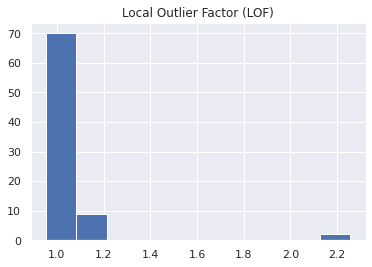

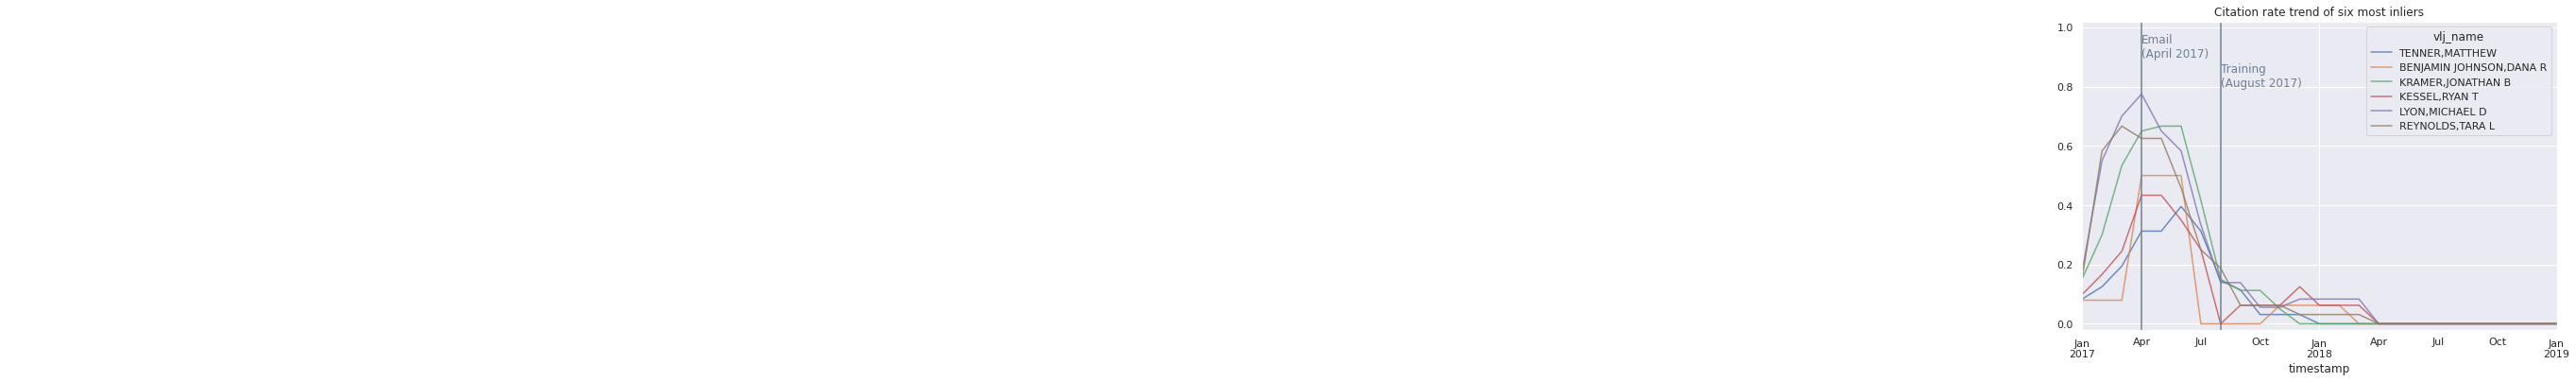

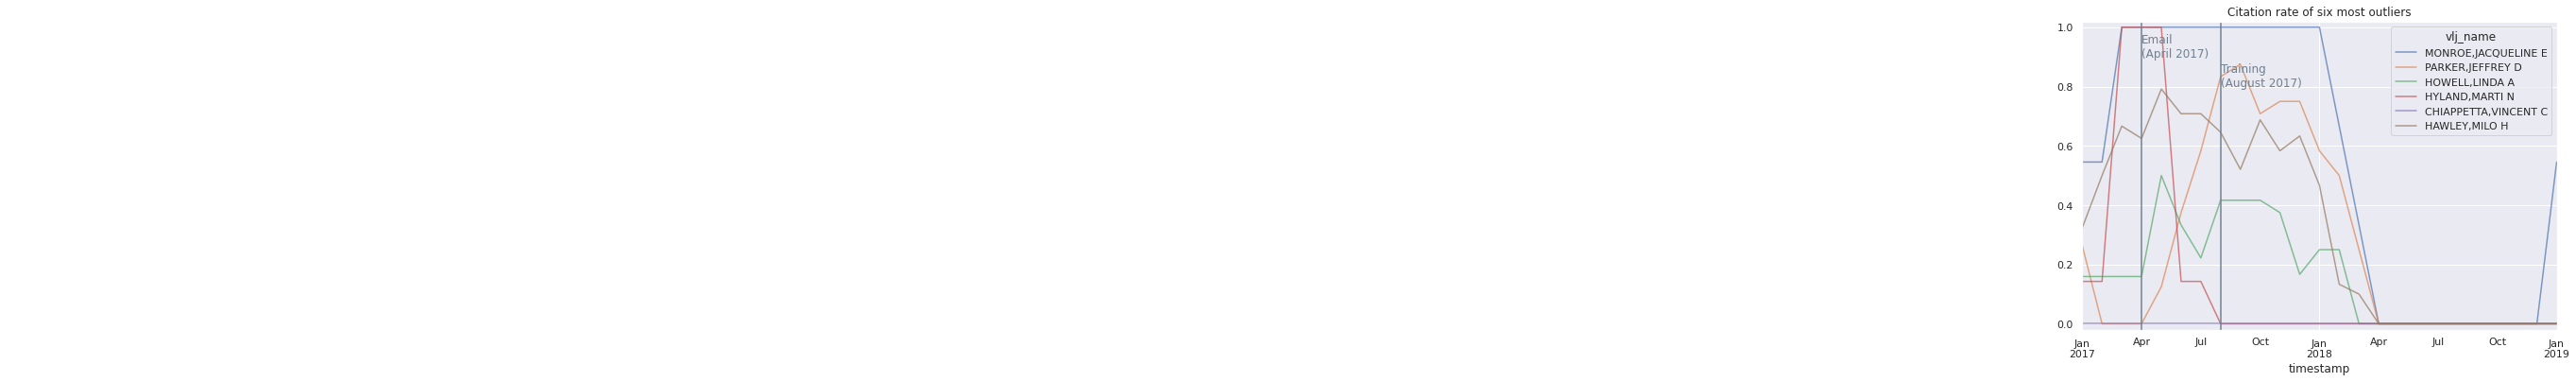

In [ ]:
outlier_analysis(
    related_df, n_neighbors=15, n_rolling=4, min_periods=2,
    nan_tolerance=6, n_inliers=6, n_outliers=6,
    annotations=[
        (datetime.datetime(2008, 4, 23), 'Case date\n(April 2008)', 0.9),
        (datetime.datetime(2017, 4, 27), 'Email\n(April 2017)', 0.9),
        (datetime.datetime(2017, 8, 31), 'Training\n(August 2017)', 0.8)
    ]
)

In [ ]:
def plot_appeal_risk_vs_citation_rate(
        related_df,
        start_date='2017-04-01', end_date=None,
        xlim=0.5, ylim=0.5, alpha=.8,
        annotate_h=0.4, annotate_v=0.5
    ):
    sns.set()
    VAR = 'appealed_cavc_appeal_level'
    related_df[VAR] = related_df[VAR].astype(int)

    condition = related_df['timestamp'] >= pd.Timestamp(start_date)
    if end_date is not None:
        condition = condition & (related_df['timestamp'] < pd.Timestamp(end_date))
    performance_df = \
        related_df[condition]\
        .groupby('vlj_name')\
        .agg(
            case_count=('appealed_cavc_appeal_level', 'count'),
            appeal_risk=('appealed_cavc_appeal_level', 'mean'),
            citation_rate=('cited', 'mean')
        )

    plt.figure(figsize=(7, 5))
    ax = plt.gca()
    cmap = sns.cubehelix_palette(start=3, rot=0, dark=0, light=.8, as_cmap=True)

    sns.scatterplot(data=performance_df,
                    x='citation_rate',
                    y='appeal_risk',
                    hue='case_count',
                    palette=cmap,
                    alpha=alpha, ax=ax)
    ax.set_xlim(-0.03, xlim + 0.03)
    ax.set_ylim(-0.03, ylim + 0.03)
    ax.set_title('Appeal risk vs. Citation rate (by individual VLJs)')

    avg_appeal_risk = performance_df.appeal_risk.mean()
    avg_citation_rate = performance_df.citation_rate.mean()
    print('avg appeal risk:', avg_appeal_risk)
    print('avg citation rate:', avg_citation_rate)

    ax.axhline(avg_appeal_risk, ls='--', alpha=.3)
    ax.annotate('avg appeal risk', (annotate_h, avg_appeal_risk), size='small')
    ax.axvline(avg_citation_rate, ls='--', alpha=.3)
    ax.annotate('avg citation rate', (avg_citation_rate, annotate_v), size='small')
    return ax, performance_df

avg appeal risk: 0.10319918664590548
avg citation rate: 0.11040538348646407


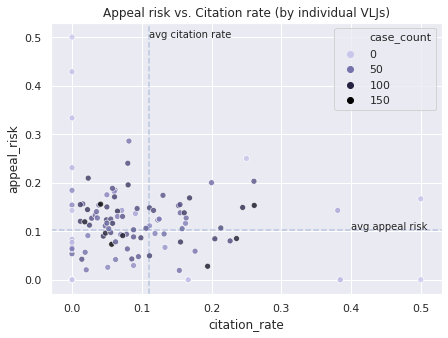

In [ ]:
# citation rate and appeal risk
ax, _ = plot_appeal_risk_vs_citation_rate(
    related_df, start_date='2017-04-01',
    xlim=0.5, ylim=0.5,
    annotate_h=0.4, annotate_v=0.5
)

### Scott v. McDonald

In [ ]:
# find related cases
related_df = df[
    (df.issprog == '2') & (df.issdc == '4')
    & (df.timestamp > pd.Timestamp('2017-02-01'))
].copy()

scott_v_mcdonald = {'case': '789 F.3d 1375'}
related_df = add_citation_indicator(related_df, scott_v_mcdonald)
related_df.head(5)

,appeal_id,bva_id,issue_id,timestamp,issdc,issseq,issprog,isscode,isslev2,isslev3,cvdocket,cvdisp,appealed_CAVC,issue_count,cvjoint,appealed_cavc_appeal_level,jmr_appeal_level,bfso,bfmemid,bfattid,vlj_name,sa_name,sdob,ctyp_ps1,ctyp_ps2,ctyp_ps3,ctyp_ps4,ctyp_ps5,ctyp_ps6,ctyp_ps7,ctyp_ps8,ctyp_ps9,cited
35,3078096,1802325,3078096-1-1,2018-01-10,4,1,2,15,7005,NA,,,0,1,0,0,0,L,370,755,"CATINO,THERESA M","MAC,MOTRYA A",1942-07-04,0,0,0,0,0,1,1,0,0,0
47,3470662,1712365,3470662-1-1,2017-04-12,4,1,2,15,7806,NA,,,0,1,0,0,0,I,790,1554,"FEINBERG,REBECCA A","WILLIAMS,JASMINE A",1946-12-01,0,0,0,0,0,0,1,0,0,0
72,3533369,1719511,3533369-1-1,2017-05-30,4,1,2,12,6100,NA,,,0,1,0,0,0,A,1028,1036,"HENNINGS,BRADLEY","GILLETT,TODD M",1956-08-31,0,0,0,0,0,0,1,1,0,0
78,2627262,18114111,2627262-1-1,2018-06-26,4,1,2,12,7806,NA,,,0,1,0,0,0,D,598,2086,"LINTON,MICHELLE L",NA,1950-07-01,0,0,0,0,0,0,0,0,0,0
86,3533139,1721287,3533139-1-1,2017-06-01,4,1,2,12,5203,NA,,,0,1,0,0,0,D,945,911,"HENEKS,STACEY R","DEFRANK,JAMES A",1959-06-23,0,0,0,0,0,0,0,1,0,0


(92, 24)
[-1.36110733 -1.3386728  -1.30988564 -1.29365273 -1.27499947 -1.27262027
 -1.24184606 -1.23890289 -1.23410662 -1.21187562 -1.2002055  -1.18724741
 -1.18311895 -1.16858805 -1.15528586 -1.15462285 -1.15418559 -1.14209541
 -1.12536872 -1.12522358 -1.1172287  -1.11209476 -1.10756812 -1.0996497
 -1.09498763 -1.08519304 -1.08451735 -1.08050618 -1.07784497 -1.07570465
 -1.07489345 -1.07404758 -1.06067558 -1.06004542 -1.05378289 -1.0521878
 -1.05133821 -1.05118659 -1.05001472 -1.0498635  -1.04813287 -1.04064277
 -1.03677272 -1.03656501 -1.02913757 -1.01928123 -1.01770955 -1.01485407
 -1.01083346 -1.0103047  -1.00677359 -1.00657592 -1.00449328 -1.00292084
 -1.00151194 -1.00122525 -1.0006113  -0.99806048 -0.99686287 -0.9964939
 -0.99452478 -0.99452478 -0.99452478 -0.99452478 -0.99452478 -0.99421104
 -0.99384068 -0.99371914 -0.99371914 -0.99308725 -0.99266832 -0.98859406
 -0.98728833 -0.98482247 -0.98196488 -0.98139073 -0.9808769  -0.97991316
 -0.97784378 -0.97773153 -0.97738905 -0.97730

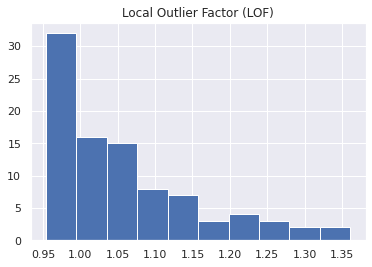

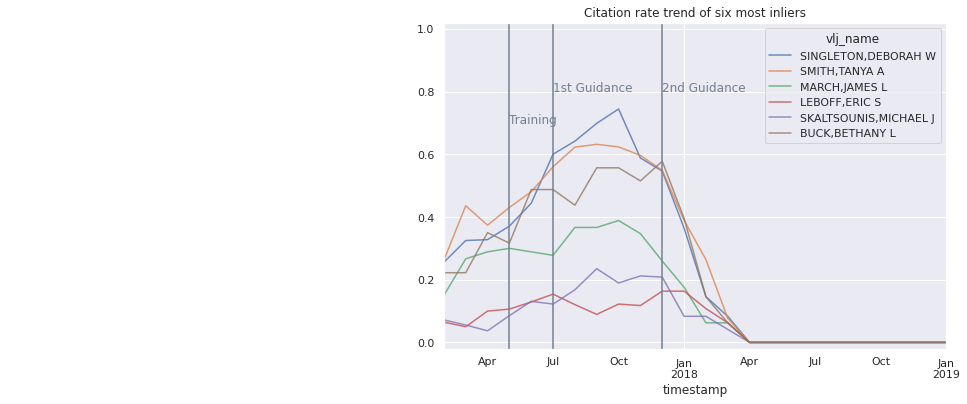

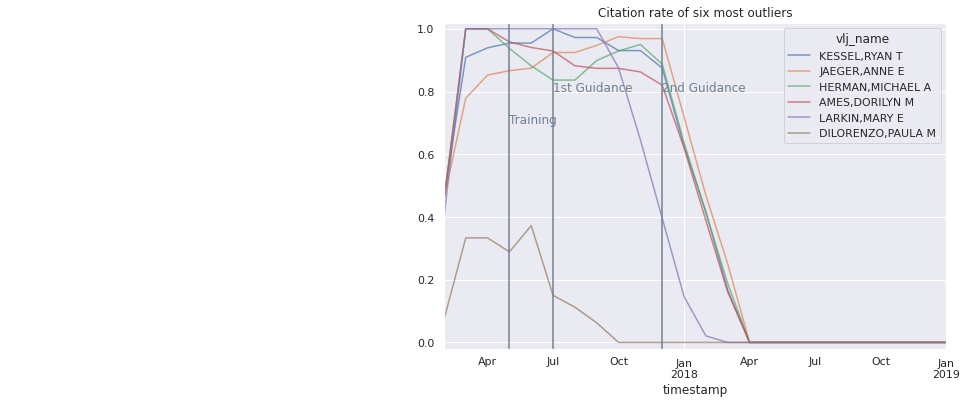

In [ ]:
outlier_analysis(
    related_df, n_neighbors=15, n_rolling=4, min_periods=2,
    nan_tolerance=6, n_inliers=6, n_outliers=6,
    annotations=[
        (datetime.datetime(2015, 6, 18), "Case Date", 0.95),
        (datetime.datetime(2017, 5, 15), "Training", 0.7),
        (datetime.datetime(2017, 7, 31), "1st Guidance", 0.8),
        (datetime.datetime(2017, 12, 8), "2nd Guidance", 0.8)
    ]
)

avg appeal risk: 0.1729774718934526
avg citation rate: 0.4475705680932194


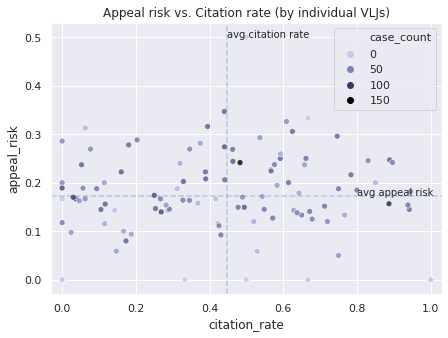

In [ ]:
# citation rate and appeal risk (before 2nd guidance)
ax, _ = plot_appeal_risk_vs_citation_rate(
    related_df,
    start_date='2017-05-01', end_date='2017-12-01',
    xlim=1.0, ylim=0.5,
    annotate_h=0.8, annotate_v=0.5
)
ax.legend(loc='upper right')

avg appeal risk: 0.16504045059725583
avg citation rate: 0.033713338546471405


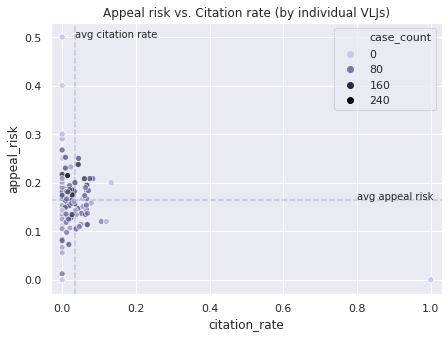

In [ ]:
# citation rate and appeal risk (after 2nd guidance)
ax, _ = plot_appeal_risk_vs_citation_rate(
    related_df, start_date='2017-12-01',
    xlim=1.0, ylim=0.5,
    annotate_h=0.8, annotate_v=0.5
)

### Johnson v. McDonald

In [186]:
# find related cases
related_df = df[
    (df.issprog == '2') & (df.isscode == '12')
    & ((df.issdc == '1') | (df.issdc == '4'))
    & (df.timestamp > pd.Timestamp('2017-09-01'))
].copy()

johnson_v_mcdonald = {'case': '762 F.3d 1362'}
related_df = add_citation_indicator(related_df, johnson_v_mcdonald)
related_df.head(5)

,appeal_id,bva_id,issue_id,timestamp,issdc,issseq,issprog,isscode,isslev2,isslev3,cvdocket,cvdisp,appealed_CAVC,issue_count,cvjoint,appealed_cavc_appeal_level,jmr_appeal_level,bfso,bfmemid,bfattid,vlj_name,sa_name,sdob,ctyp_ps1,ctyp_ps2,ctyp_ps3,ctyp_ps4,ctyp_ps5,ctyp_ps6,ctyp_ps7,ctyp_ps8,ctyp_ps9,cited
78,2627262,18114111,2627262-1-1,2018-06-26,4,1,2,12,7806,NA,,,0,1,0,0,0,D,598,2086,"LINTON,MICHELLE L",NA,1950-07-01,0,0,0,0,0,0,0,0,0,0
99,2780047,1807567,2780047-1-1,2018-02-02,4,1,2,12,NA,NA,,,0,1,0,0,0,I,467,1377,"REISS,STEVEN D","WESNER,TRACIE N",1956-07-04,0,0,0,0,0,0,1,1,1,0
144,2584788,1740858,2584788-2-1,2017-09-19,1,2,2,12,5228,NA,,,0,1,0,0,0,I,611,1491,"MAINELLI,ANTHONY J","HOWELL,CHAD R",1966-02-22,0,0,0,0,0,0,0,1,0,0
179,3534868,1749775,3534868-1-1,2017-11-01,4,1,2,12,9411,NA,,,0,1,0,0,0,D,1591,1907,"MOSHIASHWILI,VICTORIA H","SANDLER,JACQUELINE T",1968-10-25,0,0,0,0,0,0,0,1,1,0
180,3041198,18138154,3041198-1-1,2018-09-25,1,1,2,12,NA,NA,,,0,1,0,0,0,D,36,1109,"COPELAND,BARBARA B","PATEL,SHAMIL R",1969-01-11,0,0,0,0,0,0,0,0,0,0


(88, 17)
[-5.68714505e+08 -5.48083735e+08 -5.40601854e+08 -5.39241223e+08
 -4.13862756e+08 -3.70967847e+08 -3.24514294e+08 -3.23115589e+08
 -2.68125675e+08 -2.13946798e+08 -1.45303187e+08 -5.50386099e+00
 -3.09865965e+00 -2.71348539e+00 -2.54408485e+00 -2.49341644e+00
 -2.46232712e+00 -2.42143693e+00 -2.34267566e+00 -2.31486200e+00
 -2.11352621e+00 -1.98777564e+00 -1.69781823e+00 -1.65566100e+00
 -1.63716558e+00 -1.55486615e+00 -1.49725254e+00 -1.23887065e+00
 -1.22869087e+00 -1.19956724e+00 -1.18891921e+00 -1.13921194e+00
 -1.05200336e+00 -1.05200336e+00 -1.05200336e+00 -1.05200336e+00
 -1.04861928e+00 -1.04336073e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00

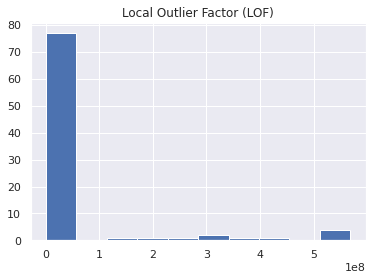

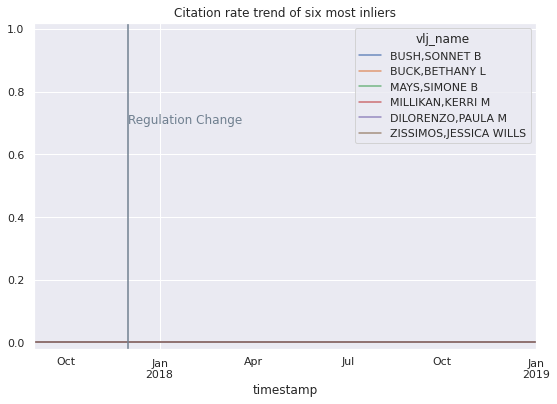

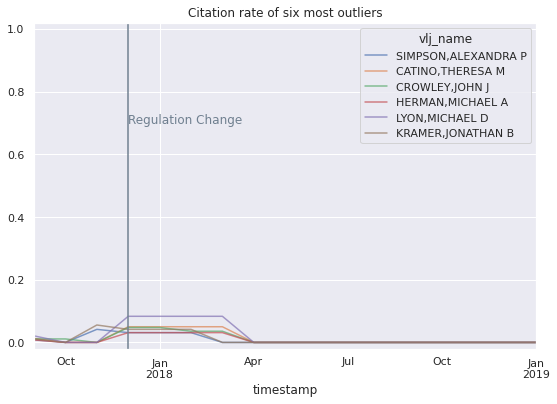

In [ ]:
outlier_analysis(
    related_df, n_neighbors=15, n_rolling=4, min_periods=2,
    nan_tolerance=6, n_inliers=6, n_outliers=6,
    annotations=[
        (datetime.datetime(2017, 12, 8), "Regulation Change", 0.7),
    ]
)

avg appeal risk: 0.09632038199666484
avg citation rate: 0.004564052426371266


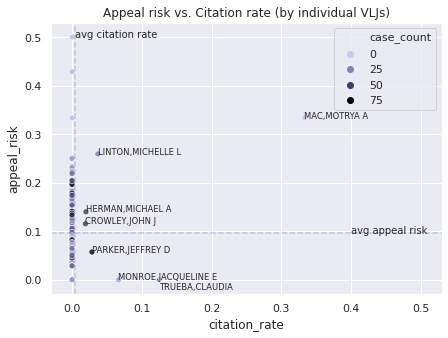

In [187]:
# citation rate and appeal risk
ax, performance_df = plot_appeal_risk_vs_citation_rate(
    related_df, start_date='2017-12-10',
    xlim=0.5, ylim=0.5, alpha=.8,
    annotate_h=0.4, annotate_v=0.5
)
slow_vljs = performance_df[
    performance_df['citation_rate'] > 0
]
for vlj in slow_vljs.iterrows():
    offset = 0.02 if vlj[0] == 'TRUEBA,CLAUDIA' else 0
    ax.annotate(vlj[0],
                (vlj[1]['citation_rate'],
                 vlj[1]['appeal_risk'] - offset),
                size='x-small')